In [33]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import imp
import sys
import scipy
import pickle as plk
import importlib.util
from numpy.lib.scimath import sqrt as csqrt
from IPython.display import display, Math, clear_output
from scipy.signal import find_peaks

###############################################################
#LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/media/leonardo/datam02/Edge-Coupler')) #Current directory

###############################################################
#WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Leo/Documents/Facul/Capacitação/GitHub/Edge-Coupler'))
spec_win.loader.exec_module(lumapi)


def imbalance(n,p):
    return 10*np.log10(p/n)

def CMRR(n,p):
    return 20*np.log10(abs((p-n)/(p+n)))

def functionstapers(lenght, N, width, function): # Generate polygons with the given function
    yinverse = np.flip(-function)
    xinverse = np.linspace(lenght,0,N)
    X = np.append(x,xinverse)
    Y = np.append(function,yinverse)
    vertices = np.column_stack((X,Y))
    lum.addpoly()
    lum.set('vertices',vertices)
    return X, Y, xinverse, yinverse

# Parameters and variables

core = 'Si (Silicon) - Palik'
substract = 'SiO2 (Glass) - Palik'

height = 0.34e-6
burriedlayer = 2e-6
finalwidth = 0.55e-6

Cband = np.linspace(1.530e-6, 1.565e-6, 2000)
band = np.linspace(1500e-9, 1600e-9, 2000)
c0 = 299792458

width = 0.04e-6
length = 200e-6
N = 200

time = 5e-12

yspan = 20e-6
zspan = 20e-6


# Linear

In [3]:
fdtd = 0 # if 0 to open mode and generate eme, 1 to open and generate FDTD

if (fdtd): lum = lumapi.FDTD(filename='../CML/Linear.fsp')
else: lum = lumapi.MODE(filename='../CML/Linear.lms')

In [34]:
# Core and substract generation

# Using 0.04μm width and 200μm length
lum.select('core')
lum.delete()
lum.select('substract')
lum.delete()
lum.select('extension')
lum.delete()
lum.select('fiber')
lum.delete()


x = np.linspace(0,length,N)
m = (width-finalwidth)/(length-0)/2
function = m*x + finalwidth/2
inversefunction = function[::-1]

functionstapers(length, N, width, inversefunction)
lum.set({
    'z min'                                      : 0,
    'z max'                                      : height,
    'x'                                          : 0,
    'y'                                          : 0,
    'material'                                   : core,
    'name'                                       : 'core',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})
lum.addrect()
lum.set({
    'x min'                                      : length,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : finalwidth,
    'z max'                                      : height,
    'z min'                                      : 0,
    'name'                                       : 'extension',
    'material'                                   : core,
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})

lum.addrect()
lum.set({
    'z'                                          : 0,
    'z span'                                     : zspan,
    'x min'                                      : 0,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : yspan,
    'material'                                   : substract,
    'name'                                       : 'substract',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 2
})

lum.addobject('cc_fiber')
lum.set({
    'first axis'  :  'y',
    'rotation 1': 90,
    'index cladding' : 1.43482,
    'index core'     : 1.44,
    'radius core'    : 4.1e-6,
    'radius cladding': 20e-6,
    'z span'         : 20e-6,
    'z'              : height/2,
    'x'              : -10e-6,
    'y'              : 0,
    'name'           : 'fiber'
})

In [37]:
# Simulation Settings

#time = (length)/c0*3.5
#print(time)
lum.switchtolayout()
meshmulti = 2
cellsmesh = 200
lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()
lum.select('EME')
lum.delete()
lum.select('mesh')
lum.delete()

if fdtd:
    # Create FDTD
    lum.addpower()
    lum.set({
        'z'                               : height/2,
        'x'                               : length/2,
        'x span'                          : length + 5e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'field',
        'override global monitor settings': 1,
        'frequency points'                : 51
    })

    lum.addpower()
    lum.set('monitor type', '2D X-normal')
    lum.set({
        'z'                               : height/2,
        'z span'                          : zspan,
        'x'                               : length + 2e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'output',
        'override global monitor settings': 1,
        'frequency points'                : 51
    })

    lum.addmode()
    lum.set({
        'x'                : -2.5e-6,
        'y'                : 0,
        'y span'           : yspan,
        'z'                : height/2,
        'z span'           : zspan,
        'name'             : 'port',
        'wavelength start' : 1.5e-6,
        'wavelength stop'  : 1.6e-6
    })

    lum.addfdtd()
    lum.set({
        'z'               : height/2,
        'z span'          : zspan,
        'x'               : length/2,
        'x span'          : length+5e-6,
        'y'               : 0,
        'y span'          : yspan,
        'mesh accuracy'   : 2,
        'y min bc'        : 'PML',
        'z min bc'        : 'PML',
        'y max bc'        : 'PML',
        'z max bc'        : 'PML',
        'simulation time' : time
    })

    
    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'core',
        'set equivalent index' : 1,
        'equivalent x index'   : meshmulti,
        'equivalent y index'   : meshmulti,
        'equivalent z index'   : meshmulti,
        })
    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'extension',
        'set equivalent index' : 1,
        'equivalent x index'   : meshmulti,
        'equivalent y index'   : meshmulti,
        'equivalent z index'   : meshmulti,
        })

else:

    # Create EME 
    lum.addeme()
    lum.set("allow custom eigensolver settings",1)
    lum.set("number of cell groups",3)
    lum.set("group spans",np.transpose([5e-6, length, 2.5e-6]))
    lum.set({
        "cells"                   :np.transpose([1, 60, 1]),
        "subcell method"          :np.transpose([0, 1, 0]), # 0 = none,  1 = CVCS
        "modes"                   :np.transpose([5, 45, 5]),
        "x min"                   :-5e-6,
        "y"                       :0,
        "y span"                  :yspan,
        "z"                       :height/2,
        "z span"                  :zspan,
        "y min bc"                :"PML",
        "y max bc"                :"PML",
        "z min bc"                :"PML",
        "z max bc"                :"PML",
        #"background material"     :"SiO2 (Glass) - Palik",
        "mesh cells y"            :cellsmesh,
        "mesh cells z"            :cellsmesh,
        "display cells"           : 0
        })
    
    lum.addemeprofile()
    lum.set({
        'z'                               : height/2,
        'x'                               : length/2,
        'x span'                          : length + 10e-6,
        'y'                               : 0,
        'y span'                          : yspan,
        'name'                            : 'field',
    })

    #Create EME Ports
    lum.select("EME::Ports::port_2")
    lum.set({"use full simulation span" :0,
        "y span"                        :2e-6,
        "z span"                        :5e-6,
        "z"                             :height/2
    })

    lum.select("EME::Ports::port_1")
    lum.set({"use full simulation span" :0,
        "y span"                        :yspan,
        "z span"                        :zspan,
        "z"                             :height/2
    })

    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'core',
        'set mesh multiplier' : 1,
        'y mesh multiplier'   : meshmulti,
        'z mesh multiplier'   : meshmulti/2,
        })
    lum.addmesh()
    lum.set({
        'based on a structure' : 1,
        'structure'            : 'extension',
        'set mesh multiplier' : 1,
        'y mesh multiplier'   : meshmulti,
        'z mesh multiplier'   : meshmulti/2,
    })


{!!}



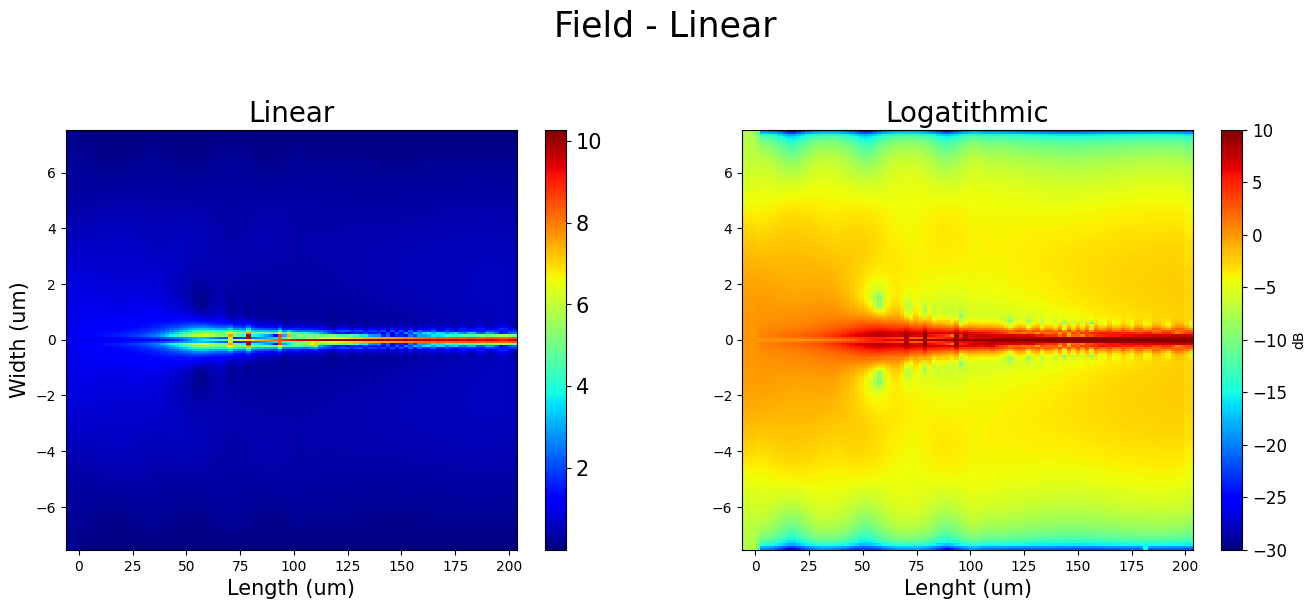

In [9]:
# Plot Linear and Log TE Mode Field Monitor Graph

figure1 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

if fdtd :field = lum.getresult('field','E')
else: field = lum.getresult('field','field profile')

x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.suptitle('Field - Linear', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 10)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_Linear')

In [29]:
 # Getting results

if fdtd:
    S = lum.getresult('output', 'T')

    T = (S['T'])
    Tlog = 10*np.log10(T)

else:

    #lum.setemeanalysis("wavelength sweep",1)
    #lum.setemeanalysis("start wavelength",1.5e-6)
    #lum.setemeanalysis("stop wavelength",1.6e-6)
    #lum.setemeanalysis("number of wavelength points",101)
    #lum.emesweep("wavelength sweep")
    S = lum.getemesweep('S_wavelength_sweep')
    T = (abs(S['s12'])**2)
    Tlog = 10*np.log10(S['s12'])


C:\Users\Leo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


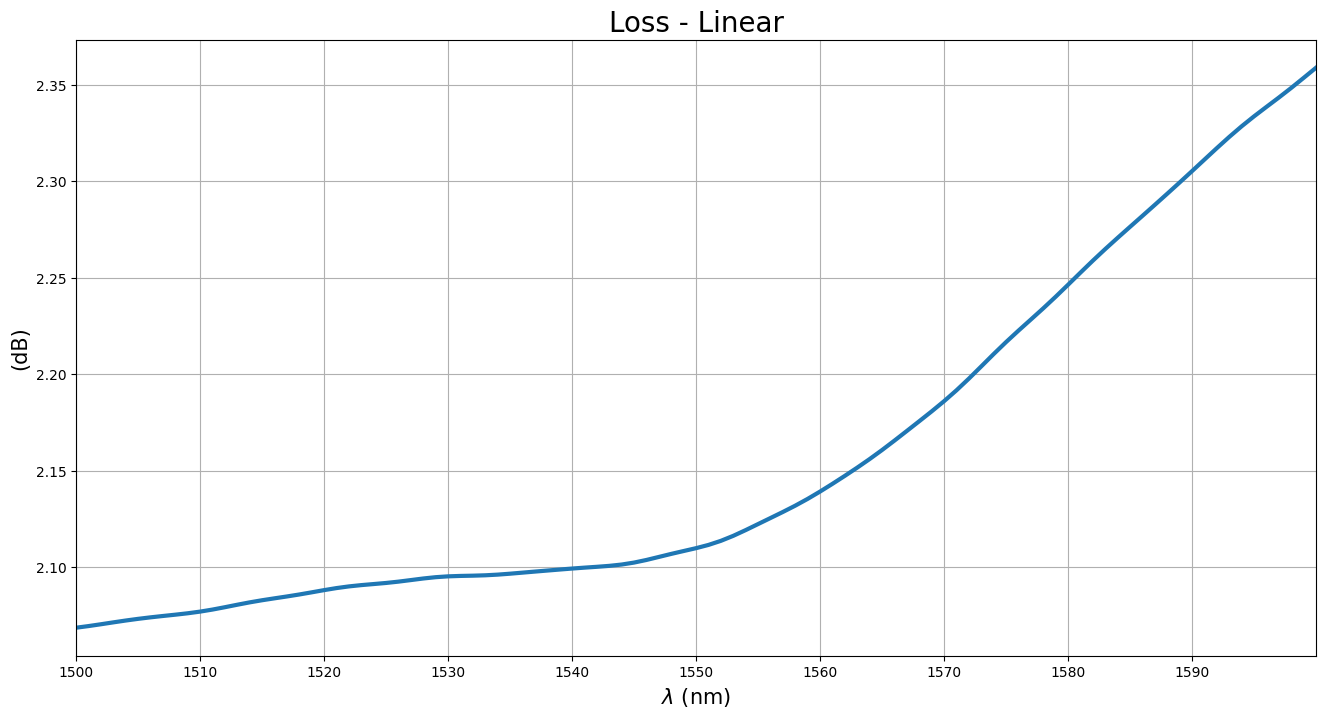

In [30]:

# Plotting insertion loss

figure3 = plt.figure(figsize=(16,8))

plt.title('Loss - Linear', size = 20)
wavelength = np.linspace(1500,1600,len(T))
plt.plot(wavelength, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/Loss_Linear')

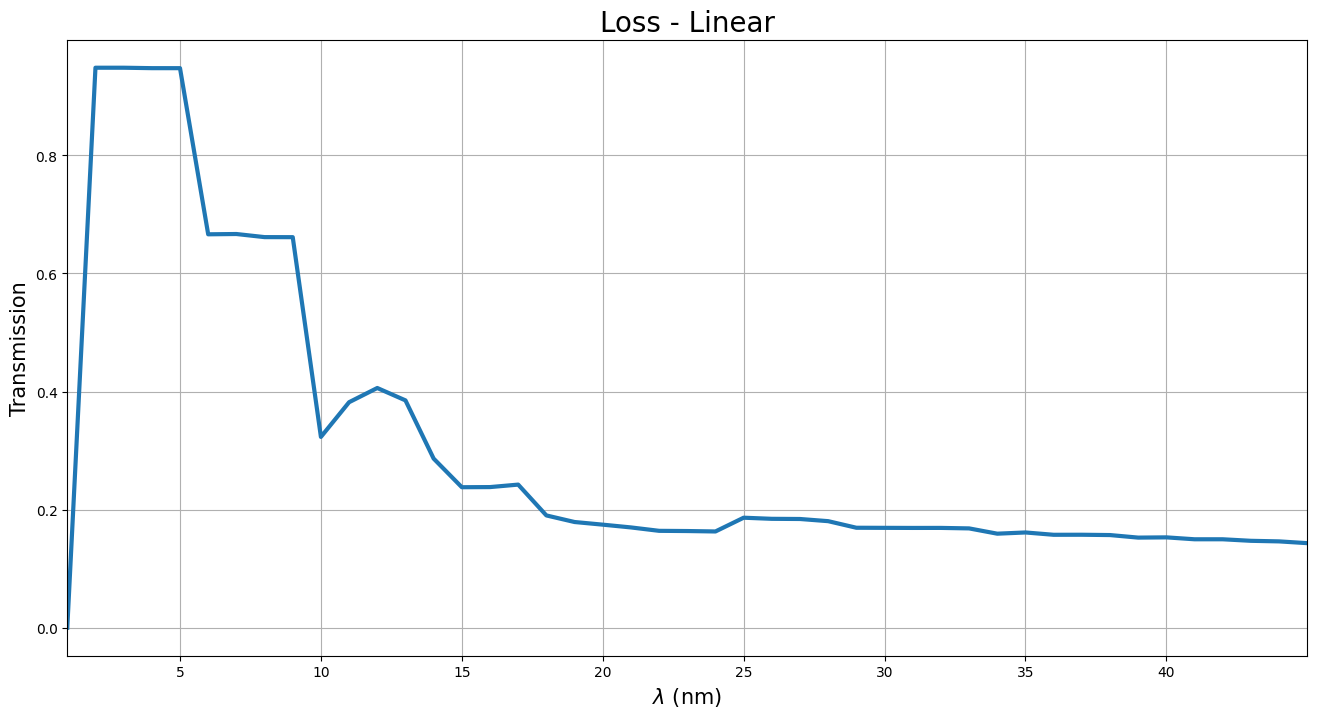

In [27]:

# Plotting Mode convergence
S = lum.getemesweep('S_mode_convergence_sweep')
T = (abs(S['s12'])**2)
modes = S['modes']

figure4 = plt.figure(figsize=(16,8))

plt.title('Loss - Linear', size = 20)
wavelength = np.linspace(1500,1600,len(T))
plt.plot(modes, abs(T)**2, linewidth = 3)
plt.xticks(np.arange(0,45,5))
plt.xlim(1,45)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('Transmission', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/Mode_convergence_Lin')

In [31]:
with open('SavedData/Loss_Lin.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [32]:
with open('SavedData/Loss_Lin.txt', 'rb') as file:
    Loss_Lin = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Loss_Lin) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.385709+0.000000j,0.385558+0.000000j,0.385391+0.000000j,0.385217+0.000000j,0.385049+0.000000j,0.384894+0.000000j,0.384756+0.000000j,0.384631+0.000000j,0.384512+0.000000j,0.384383+0.000000j,...,0.344957+0.000000j,0.344014+0.000000j,0.343096+0.000000j,0.342228+0.000000j,0.341416+0.000000j,0.340647+0.000000j,0.339889+0.000000j,0.339108+0.000000j,0.338298+0.000000j,0.337478+0.000000j
1,-2.068703-12.265539j,-2.069550+6.544867j,-2.070492-1.920882j,-2.071472-10.375349j,-2.072421+8.468964j,-2.073294+0.037013j,-2.074074-8.383648j,-2.074777+10.494540j,-2.075452+2.096545j,-2.076178-6.290113j,...,-2.311173-3.080365j,-2.317121-10.615643j,-2.322920+9.145762j,-2.328425+1.628867j,-2.333580-5.878635j,-2.338476-13.376574j,-2.343317+6.422633j,-2.348307-1.056190j,-2.353506-8.525763j,-2.358770+11.301213j


# Exponential

In [4]:
lum = lumapi.FDTD(filename='../CML/Exponential.fsp')

In [10]:
# Using 0.04μm width and 200μm lenght
lum.select('core')
lum.delete()
lum.select('substract')
lum.delete()
lum.select('extension')
lum.delete()


width = 0.04e-6
lenght = 200e-6
N = 200

x = np.linspace(0,lenght,N)
a = (finalwidth/2 / width) ** (1/(N-1))
function = np.array([width * (a ** i) for i in range(N)])

X, Y, xinverse, yinverse = functionstapers(lenght, N, finalwidth, -function)
lum.set({
    'z min'                                      : 0,
    'z max'                                      : height,
    'x'                                          : 0,
    'y'                                          : 0,
    'material'                                   : core,
    'name'                                       : 'core',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})
lum.addrect()
lum.set({
    'x min'                                      : length,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : finalwidth,
    'z max'                                      : height,
    'z min'                                      : 0,
    'name'                                       : 'extension',
    'material'                                   : core,
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})

lum.addrect()
lum.set({
    'z'                                          : 0,
    'z span'                                     : 2*burriedlayer,
    'x min'                                      : 0,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : 3*burriedlayer,
    'material'                                   : substract,
    'name'                                       : 'substract',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 2
})



In [8]:
# Simulation Settings

#time = (length)/c0*3.5
#print(time)

lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()
lum.select('mesh')
lum.delete()

lum.addpower()
lum.set({
    'z'                               : height/2,
    'x'                               : length/2,
    'x span'                          : length + 5e-6,
    'y'                               : 0,
    'y span'                          : yspan,
    'name'                            : 'field',
    'override global monitor settings': 1,
    'frequency points'                : 51
})

lum.addpower()
lum.set('monitor type', '2D X-normal')
lum.set({
    'z'                               : height/2,
    'z span'                          : 3e-6,
    'x'                               : length + 2e-6,
    'y'                               : 0,
    'y span'                          : 3e-6,
    'name'                            : 'output',
    'override global monitor settings':1,
    'frequency points'                : 51
})

lum.addmode()
lum.set({
    'x'                : -2.5e-6,
    'y'                : 0,
    'y span'           : yspan,
    'z'                : height/2,
    'z span'           : zspan,
    'name'             : 'port',
    'wavelength start' : 1.5e-6,
    'wavelength stop'  : 1.6e-6
})

lum.addfdtd()
lum.set({
    'z'               : height/2,
    'z span'          : zspan,
    'x'               : length/2,
    'x span'          : length+5e-6,
    'y'               : 0,
    'y span'          : yspan,
    'mesh accuracy'   : 2,
    #'y min bc'        : 'Anti-Symmetric',
    'z min bc'        : 'Symmetric',
    'simulation time' : time
})

lum.addmesh()
lum.set({
    'based on a structure' : 1,
    'structure'            : 'core',
    'set equivalent index' : 1,
    'equivalent x index'   : 5,
    'equivalent y index'   : 5,
    'equivalent z index'   : 5,
    })
lum.addmesh()
lum.set({
    'based on a structure' : 1,
    'structure'            : 'extension',
    'set equivalent index' : 1,
    'equivalent x index'   : 5,
    'equivalent y index'   : 5,
    'equivalent z index'   : 5,
    })

{!!}



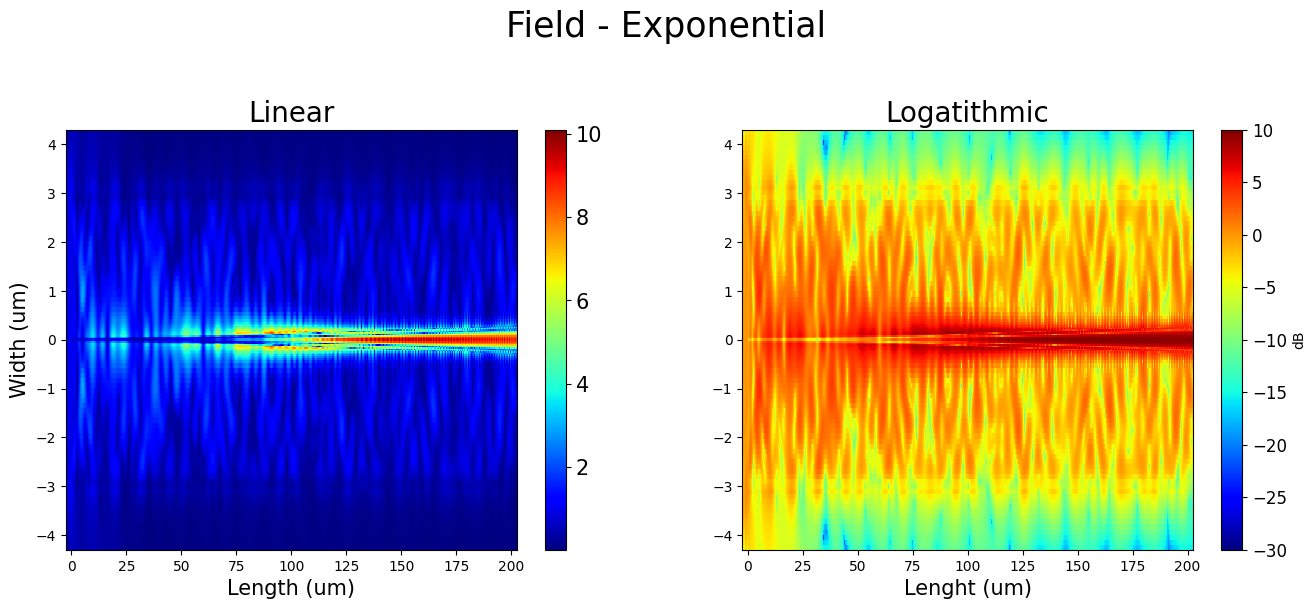

In [12]:
# Plot Linear and Log Field Monitor Graph

figure3 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = lum.getresult('field','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.suptitle('Field - Exponential', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 10)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_Exponential')

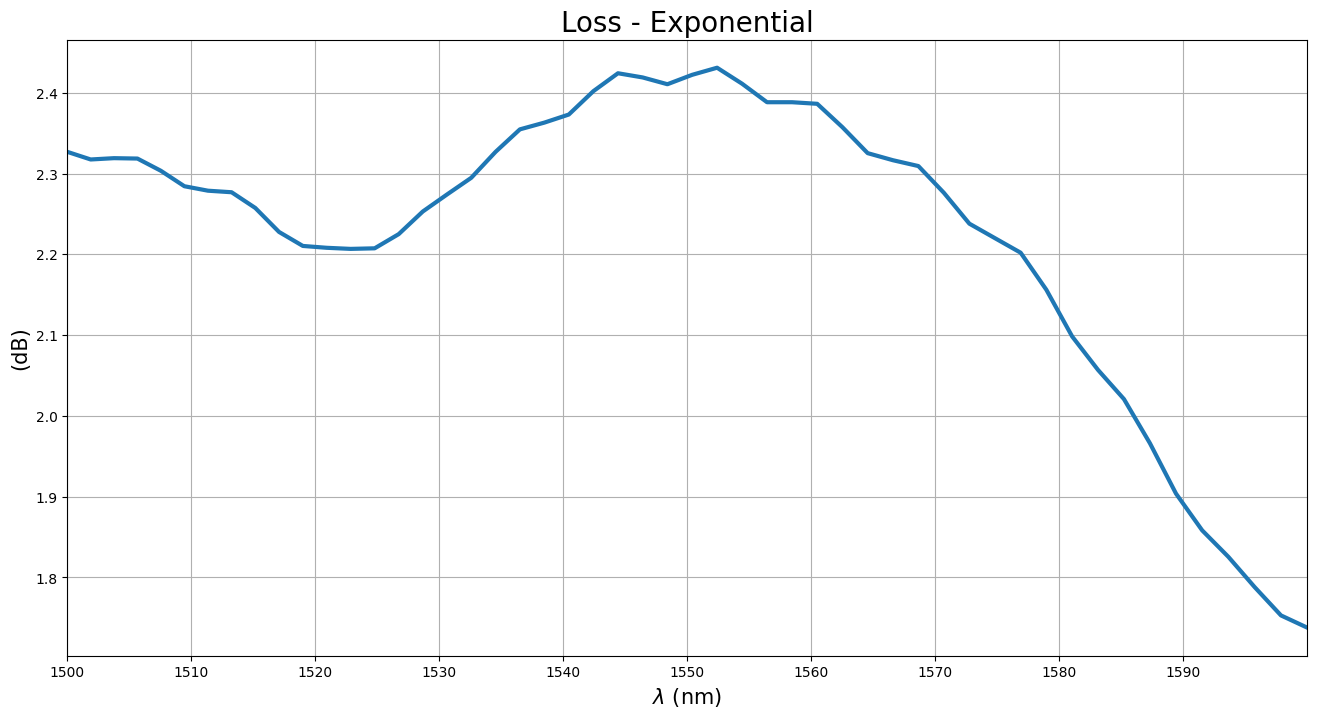

In [9]:
 # Getting results
S = lum.getresult('output', 'T')

T = (S['T'])
Tlog = 10*np.log10(T)
wavelength = S['lambda']

# Plotting transmission and insertion loss

figure4 = plt.figure(figsize=(16,8))

plt.title('Loss - Exponential', size = 20)

plt.plot(wavelength*1e9, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/Loss_Exponential')

In [13]:
with open('SavedData/Loss_Exp.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [12]:
with open('SavedData/Loss_Exp.txt', 'rb') as file:
    Loss_Exp = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Loss_Exp) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.670223,0.667877,0.662505,0.656817,0.651877,0.645091,0.635903,0.627942,0.622743,0.616832,...,0.598732,0.594651,0.591996,0.591735,0.590982,0.588388,0.586339,0.586274,0.586493,0.585225
1,-1.737809,-1.753034,-1.788109,-1.825555,-1.858342,-1.903788,-1.966088,-2.020803,-2.056911,-2.098332,...,-2.227677,-2.257376,-2.276811,-2.278726,-2.284255,-2.303365,-2.318514,-2.318993,-2.317369,-2.326771


# Quadratic

In [2]:
lum = lumapi.FDTD(filename='../CML/Quadratic.fsp')

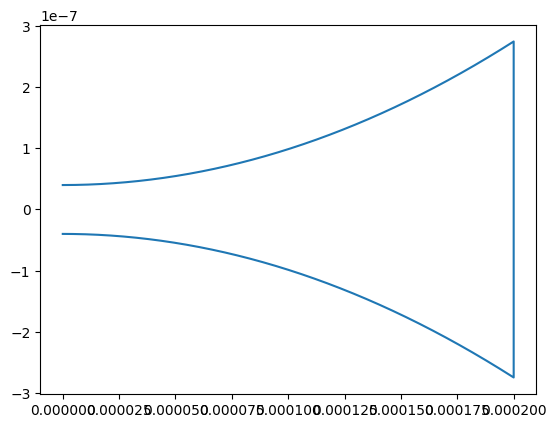

In [3]:
# Using 0.04μm width and 200μm lenght
lum.select('core')
lum.delete()
lum.select('substract')
lum.delete()
lum.select('extension')
lum.delete()

width = 0.04e-6
lenght = 200e-6
N = 2000

x = np.linspace(0,lenght,N)

a = (finalwidth/2 - width) / ((N-1) ** 2)
function = np.array([width + a * (i ** 2) for i in range(N)])

X, Y, xinverse, yinverse = functionstapers(lenght, N, width, function)
plt.plot(X,Y)
lum.set({
    'z min'                                      : 0,
    'z max'                                      : height,
    'x'                                          : 0,
    'y'                                          : 0,
    'material'                                   : core,
    'name'                                       : 'core',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})
lum.addrect()
lum.set({
    'x min'                                      : length,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : finalwidth,
    'z max'                                      : height,
    'z min'                                      : 0,
    'name'                                       : 'extension',
    'material'                                   : core,
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})

lum.addrect()
lum.set({
    'z'                                          : 0,
    'z span'                                     : 2*burriedlayer,
    'x min'                                      : 0,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : 3*burriedlayer,
    'material'                                   : substract,
    'name'                                       : 'substract',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 2
})

In [4]:
# Simulation Settings

#time = (length)/c0*3.5
#print(time)

lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()
lum.select('mesh')
lum.delete()

lum.addpower()
lum.set({
    'z'                               : height/2,
    'x'                               : length/2,
    'x span'                          : length + 5e-6,
    'y'                               : 0,
    'y span'                          : yspan,
    'name'                            : 'field',
    'override global monitor settings': 1,
    'frequency points'                : 51
})

lum.addpower()
lum.set('monitor type', '2D X-normal')
lum.set({
    'z'                               : height/2,
    'z span'                          : 3e-6,
    'x'                               : length + 2e-6,
    'y'                               : 0,
    'y span'                          : 3e-6,
    'name'                            : 'output',
    'override global monitor settings':1,
    'frequency points'                : 51
})

lum.addmode()
lum.set({
    'x'                : -2.5e-6,
    'y'                : 0,
    'y span'           : yspan,
    'z'                : height/2,
    'z span'           : zspan,
    'name'             : 'port',
    'wavelength start' : 1.5e-6,
    'wavelength stop'  : 1.6e-6
})

lum.addfdtd()
lum.set({
    'z'               : height/2,
    'z span'          : zspan,
    'x'               : length/2,
    'x span'          : length+5e-6,
    'y'               : 0,
    'y span'          : yspan,
    'mesh accuracy'   : 2,
    #'y min bc'        : 'Anti-Symmetric',
    'z min bc'        : 'Symmetric',
    'simulation time' : time
})

lum.addmesh()
lum.set({
    'based on a structure' : 1,
    'structure'            : 'core',
    'set equivalent index' : 1,
    'equivalent x index'   : 5,
    'equivalent y index'   : 5,
    'equivalent z index'   : 5,
    })
lum.addmesh()
lum.set({
    'based on a structure' : 1,
    'structure'            : 'extension',
    'set equivalent index' : 1,
    'equivalent x index'   : 5,
    'equivalent y index'   : 5,
    'equivalent z index'   : 5,
    })

{!!}



C:\Program Files\Lumerical\v202\api\python\lumapi.py:138: UserWarning: Multiple objects named '::model::mesh'. Use of this object may give unexpected results.
  warnings.warn(message)


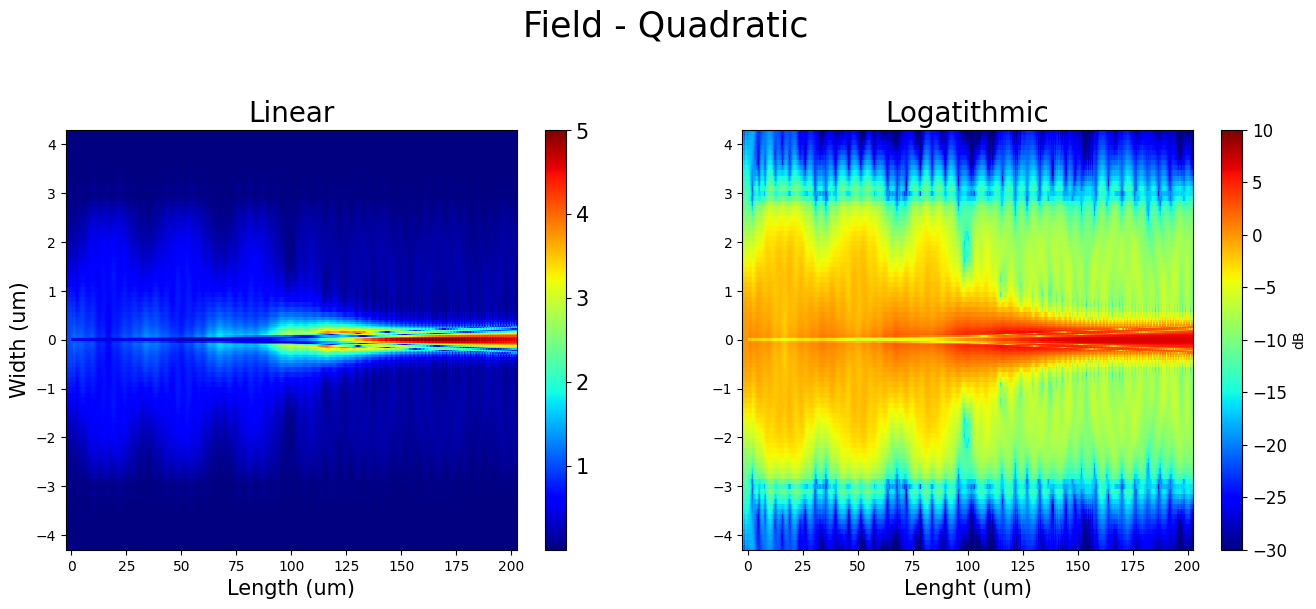

In [3]:
# Plot Linear and Log Field Monitor Graph

figure1 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = lum.getresult('field','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.suptitle('Field - Quadratic', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 10)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_Quadratic')

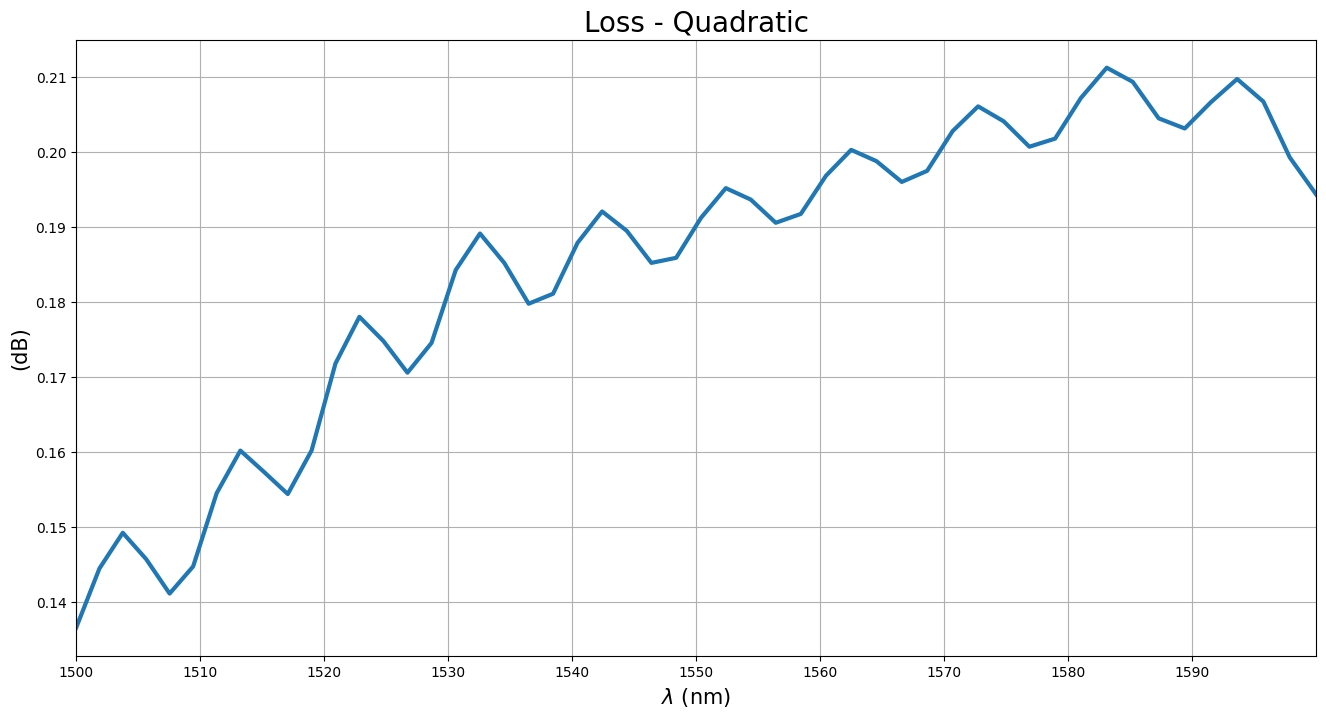

In [4]:
 # Getting results
S = lum.getresult('output', 'T')

T = (S['T'])
Tlog = 10*np.log10(T)
wavelength = S['lambda']

# Plotting transmission and insertion loss

figure3 = plt.figure(figsize=(16,8))

plt.title('Loss - Quadratic', size = 20)

plt.plot(wavelength*1e9, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/Loss_Quadratic')

In [5]:
with open('SavedData/Loss_Qua.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [6]:
with open('SavedData/Loss_Qua.txt', 'rb') as file:
    Loss_Qua = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Loss_Qua) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.956234,0.955146,0.953509,0.952848,0.953527,0.954297,0.954000,0.952930,0.952517,0.953404,...,0.965080,0.964425,0.963792,0.965052,0.96723,0.968037,0.967013,0.966230,0.967292,0.969054
1,-0.194359,-0.199304,-0.206751,-0.209764,-0.206670,-0.203162,-0.204515,-0.209391,-0.211272,-0.207229,...,-0.154366,-0.157313,-0.160165,-0.154494,-0.14470,-0.141081,-0.145675,-0.149193,-0.144426,-0.136521
